### XOR

In [1]:
import torch.nn.functional as F
from torch_explain.nn.concepts import ConceptReasoningLayer, IntpLinearLayer1, IntpLinearLayer2, IntpLinearLayer3
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import logging
import warnings
warnings.filterwarnings('ignore')
# Set the logging level for matplotlib to WARNING to suppress debug information
logging.getLogger('matplotlib').setLevel(logging.WARNING)


PATH = 'models/'

2024-07-27 15:45:14,812 - matplotlib - DEBUG - matplotlib data path: d:\Github\pytorch_explain\env\Lib\site-packages\matplotlib\mpl-data
2024-07-27 15:45:14,822 - matplotlib - DEBUG - CONFIGDIR=C:\Users\a_h9\.matplotlib
2024-07-27 15:45:14,858 - matplotlib - DEBUG - interactive is False
2024-07-27 15:45:14,859 - matplotlib - DEBUG - platform is win32
2024-07-27 15:45:14,980 - matplotlib - DEBUG - CACHEDIR=C:\Users\a_h9\.matplotlib
2024-07-27 15:45:14,987 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\a_h9\.matplotlib\fontlist-v390.json
2024-07-27 15:45:15,470 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-07-27 15:45:15,473 - matplotlib.pyplot - DEBUG - Loaded backend inline version unknown.


In [2]:
from torch_explain.datasets import xor
x, c, y = xor(10000)

In [3]:
y = F.one_hot(y.long().ravel()).float()

LLR 1

In [4]:
isBias = True

In [5]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 16),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(16, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer1(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [6]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR1_XOR_3.pth')))

<All keys matched successfully>

In [7]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [8]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 2]), torch.Size([10000, 2, 2]), torch.Size([10000, 2]))

In [9]:
df_all = pd.DataFrame()
df_all['c0'] = c[:,0].detach().numpy()
df_all['c1'] = c[:,1].detach().numpy()
df_all['w0_y0'] = weights[:,0,0].detach().numpy()
df_all['w1_y0'] = weights[:,1,0].detach().numpy()
df_all['w0_y1'] = weights[:,0,1].detach().numpy()
df_all['w1_y1'] = weights[:,1,1].detach().numpy()
df_all['b_y0'] = biases[:,0].detach().numpy()
df_all['b_y1'] = biases[:,1].detach().numpy()
df_all['y0'] = y[:,0].detach().numpy()
df_all['y1'] = y[:,1].detach().numpy()
df_all['y_pred0'] = y_pred[:,0].detach().numpy()
df_all['y_pred1'] = y_pred[:,1].detach().numpy()

In [10]:
temp = df_all[['y_pred0', 'y_pred1']].apply(lambda x: torch.sigmoid(torch.tensor([x[0], x[1]])).numpy(), axis=1).to_numpy()
arr_as_list = [list(sub_array) for sub_array in temp]
arr_converted = np.array(arr_as_list)
column_0 = arr_converted[:, 0]
column_1 = arr_converted[:, 1]

df_all['y_pred0'] = column_0
df_all['y_pred1'] = column_1

In [11]:
df_all.head()

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
0,0.0,1.0,0.007347,0.321780,0.927942,4.645946e-01,-4.177123,3.426290,0.0,1.0,0.020728,0.979986
1,1.0,1.0,0.938529,0.999224,0.022038,1.531706e-04,1.918523,-3.161482,1.0,0.0,0.979255,0.041515
2,0.0,0.0,0.999715,0.999980,0.000021,9.466083e-07,3.495018,-3.543387,1.0,0.0,0.970546,0.028103
3,0.0,1.0,0.733234,0.011280,0.012278,9.850787e-01,-3.151182,2.697158,0.0,1.0,0.041491,0.975451
4,1.0,1.0,0.999467,0.925943,0.000109,2.600973e-02,1.522113,-2.856632,1.0,0.0,0.969054,0.055697


In [12]:
df0= df_all[['c0', 'c1', 'w0_y0', 'w1_y0', 'b_y0']][df_all['y_pred0'] > 0.5]
df1= df_all[['c0', 'c1', 'w0_y1', 'w1_y1', 'b_y1']][df_all['y_pred1'] > 0.5]

In [13]:
df0_mean = df0[['w0_y0', 'w1_y0', 'b_y0']].mean(axis=0)
df0_mean

w0_y0    0.935264
w1_y0    0.942618
b_y0     2.556887
dtype: float32

In [14]:
df1_mean = df1[['w0_y1', 'w1_y1', 'b_y1']].mean(axis=0)
df1_mean

w0_y1    0.582388
w1_y1    0.559616
b_y1     2.588506
dtype: float32

In [15]:
import random
def plotting_function(df_1, title):

    fig, ax = plt.subplots()

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # Assuming df_1 is correctly calculated before this snippet
    bar_width = 0.5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
    colors = random.sample(colors, len(df_1))
    hatches = ['/', '-', '|', '\\']  # Different hatches for each bar
    hatches = random.sample(hatches, len(df_1))
    bars = ax.bar(df_1.index, softmax(df_1), bar_width, color=colors, edgecolor='black')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        
    ax.set_ylabel('Mean Absolute Value')
    ax.set_title(title)
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    ax.set_ylim([0, 0.6])

    # Enhanced label positioning
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

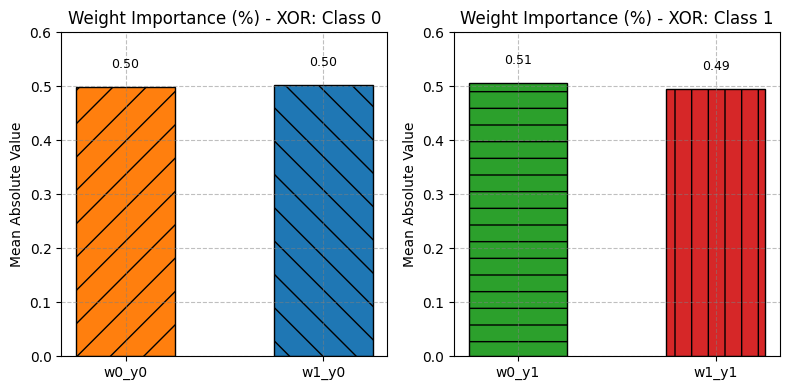

In [16]:
def plotting_function_combined(df0_mean, df1_mean):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def plot_single(ax, df, title, colors, hatches):
        bar_width = 0.5
        bars = ax.bar(df.index, softmax(df), bar_width, color=colors, edgecolor='black')
        
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        ax.set_ylabel('Mean Absolute Value')
        ax.set_title(title)
        ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
        ax.set_ylim([0, 0.6])

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hatches = ['/', '-', '|', '\\']
    random.shuffle(colors)
    random.shuffle(hatches)

    plot_single(axes[0], df0_mean, "Weight Importance (%) - XOR: Class 0", colors[:2], hatches[:2])
    plot_single(axes[1], df1_mean, "Weight Importance (%) - XOR: Class 1", colors[2:], hatches[2:])

    plt.tight_layout()
    plt.show()


plotting_function_combined(df0_mean[['w0_y0', 'w1_y0']], df1_mean[['w0_y1', 'w1_y1']])

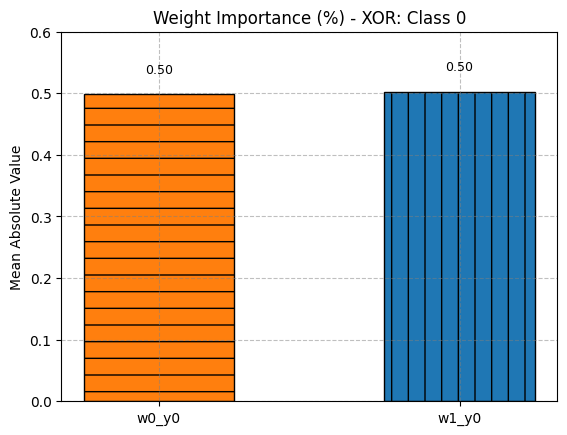

In [17]:
plotting_function(df0_mean[['w0_y0', 'w1_y0']], title="Weight Importance (%) - XOR: Class 0")

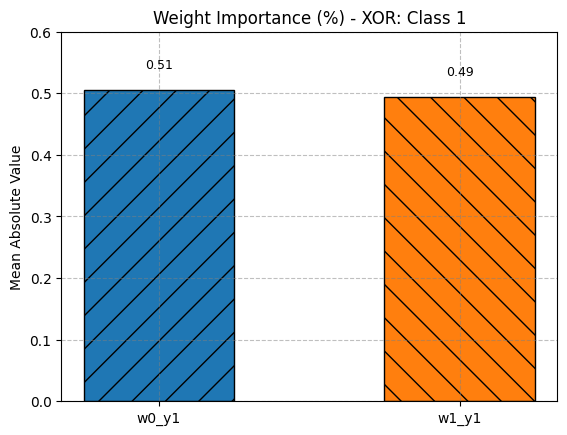

In [18]:
plotting_function(df1_mean[['w0_y1', 'w1_y1']], title="Weight Importance (%) - XOR: Class 1")

In [19]:
df00= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5)]
df01= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5)]
df10= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5)]
df11= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5)]

In [20]:
# concat all Series df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0) into a DataFrame
df_mean = pd.concat([df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0)], axis=1)
df_mean.columns = ['00', '01', '10', '11']
df_mean = df_mean.T

In [21]:
df_mean

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
00,0.0,0.0,0.970249,0.983331,0.019338,0.010405,3.167359,-3.210577,1.0,0.0,0.945652,0.053502
01,0.0,1.0,0.531052,0.089861,0.238029,0.863167,-3.299810,2.635902,0.0,1.0,0.054987,0.953198
10,1.0,0.0,0.045964,0.591899,0.932063,0.250439,-3.254440,2.508343,0.0,1.0,0.056243,0.949227
11,1.0,1.0,0.908712,0.904788,0.052095,0.050504,1.968813,-3.345827,1.0,0.0,0.954567,0.062086


LLR 3

In [22]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 16),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(16, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer3(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [23]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR3_XOR_3.pth')))

<All keys matched successfully>

In [24]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [25]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 2]), torch.Size([10000, 2, 2]), torch.Size([10000, 2]))

In [26]:
df_all = pd.DataFrame()
df_all['c0'] = c[:,0].detach().numpy()
df_all['c1'] = c[:,1].detach().numpy()
df_all['w0_y0'] = weights[:,0,0].detach().numpy()
df_all['w1_y0'] = weights[:,1,0].detach().numpy()
df_all['w0_y1'] = weights[:,0,1].detach().numpy()
df_all['w1_y1'] = weights[:,1,1].detach().numpy()
df_all['b_y0'] = biases[:,0].detach().numpy()
df_all['b_y1'] = biases[:,1].detach().numpy()
df_all['y0'] = y[:,0].detach().numpy()
df_all['y1'] = y[:,1].detach().numpy()
df_all['y_pred0'] = y_pred[:,0].detach().numpy()
df_all['y_pred1'] = y_pred[:,1].detach().numpy()

In [27]:
temp = df_all[['y_pred0', 'y_pred1']].apply(lambda x: torch.sigmoid(torch.tensor([x[0], x[1]])).numpy(), axis=1).to_numpy()
arr_as_list = [list(sub_array) for sub_array in temp]
arr_converted = np.array(arr_as_list)
column_0 = arr_converted[:, 0]
column_1 = arr_converted[:, 1]

df_all['y_pred0'] = column_0
df_all['y_pred1'] = column_1

In [28]:
df_all.head()

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
0,0.0,1.0,-0.999993,-0.957452,0.999989,0.954051,-3.137362,3.091987,0.0,1.0,0.016381,0.982814
1,1.0,1.0,0.991301,0.999930,-0.991816,-0.999904,2.120436,-2.020886,1.0,0.0,0.983847,0.017805
2,0.0,0.0,0.215270,0.050028,-0.305649,-0.107072,3.332472,-3.285584,1.0,0.0,0.965526,0.036069
3,0.0,1.0,-0.999999,-1.000000,0.999998,1.000000,-2.682374,2.775222,0.0,1.0,0.024546,0.977582
4,1.0,1.0,0.999830,0.997517,-0.999778,-0.997002,1.709494,-1.797374,1.0,0.0,0.976001,0.022037


In [29]:
df0= df_all[['c0', 'c1', 'w0_y0', 'w1_y0', 'b_y0']][df_all['y_pred0'] > 0.5]
df1= df_all[['c0', 'c1', 'w0_y1', 'w1_y1', 'b_y1']][df_all['y_pred1'] > 0.5]

In [30]:
df0_mean = df0[['w0_y0', 'w1_y0', 'b_y0']].mean(axis=0)
df0_mean

w0_y0    0.489250
w1_y0    0.474550
b_y0     2.666755
dtype: float32

In [31]:
df1_mean = df1[['w0_y1', 'w1_y1', 'b_y1']].mean(axis=0)
df1_mean

w0_y1    0.952356
w1_y1    0.947617
b_y1     2.532379
dtype: float32

In [32]:
import random
def plotting_function(df_1):

    fig, ax = plt.subplots()

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # Assuming df_1 is correctly calculated before this snippet
    bar_width = 0.5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
    colors = random.sample(colors, len(df_1))
    hatches = ['/', '-', '|', '\\']  # Different hatches for each bar
    hatches = random.sample(hatches, len(df_1))
    bars = ax.bar(df_1.index, softmax(df_1), bar_width, color=colors, edgecolor='black')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        
    ax.set_ylabel('Mean Absolute Value')
    ax.set_title('Mean Absolute Values of Weights (without Softmax)')
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    ax.set_ylim([0, 0.6])

    # Enhanced label positioning
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

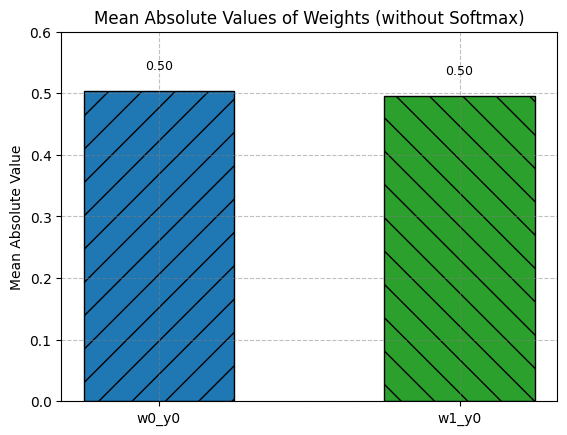

In [33]:
plotting_function(df0_mean[['w0_y0', 'w1_y0']])

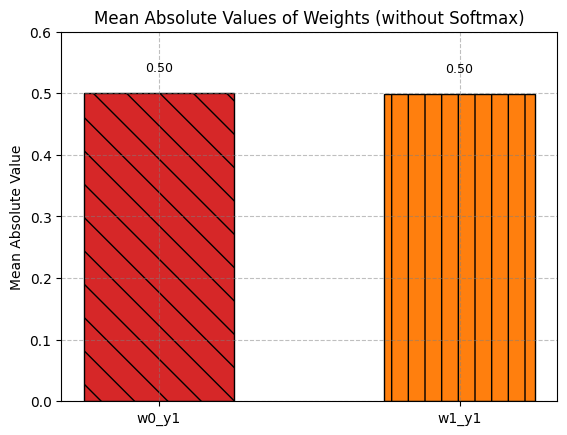

In [34]:
plotting_function(df1_mean[['w0_y1', 'w1_y1']])

In [35]:
df00= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5)]
df01= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5)]
df10= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5)]
df11= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5)]

In [36]:
# concat all Series df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0) into a DataFrame
df_mean = pd.concat([df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0)], axis=1)
df_mean.columns = ['00', '01', '10', '11']
df_mean = df_mean.T

In [37]:
df_mean.round(3)

,c0,c1,w0_y0,w1_y0,w0_y1,w1_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
00,0.0,0.0,0.031,-0.005,-0.059,-0.003,3.238,-3.237,1.0,0.0,0.949,0.050
01,0.0,1.0,-0.954,-0.911,0.955,0.912,-2.489,2.488,0.0,1.0,0.047,0.952
10,1.0,0.0,-0.925,-0.961,0.921,0.963,-2.514,2.523,0.0,1.0,0.049,0.951
11,1.0,1.0,0.948,0.962,-0.951,-0.959,2.141,-2.148,1.0,0.0,0.970,0.030


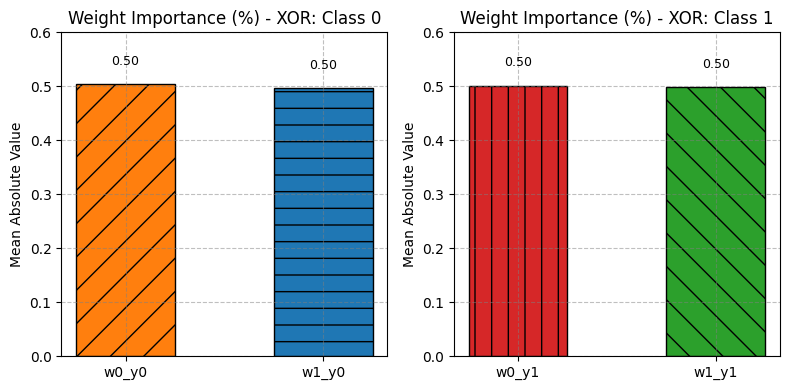

In [38]:
def plotting_function_combined(df0_mean, df1_mean):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def plot_single(ax, df, title, colors, hatches):
        bar_width = 0.5
        bars = ax.bar(df.index, softmax(df), bar_width, color=colors, edgecolor='black')
        
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        ax.set_ylabel('Mean Absolute Value')
        ax.set_title(title)
        ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
        ax.set_ylim([0, 0.6])

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hatches = ['/', '-', '|', '\\']
    random.shuffle(colors)
    random.shuffle(hatches)

    plot_single(axes[0], df0_mean, "Weight Importance (%) - XOR: Class 0", colors[:2], hatches[:2])
    plot_single(axes[1], df1_mean, "Weight Importance (%) - XOR: Class 1", colors[2:], hatches[2:])

    plt.tight_layout()
    plt.show()


plotting_function_combined(df0_mean[['w0_y0', 'w1_y0']], df1_mean[['w0_y1', 'w1_y1']])